In [1]:
print(f"ipython: {str(get_ipython())}")
from IPython.display import clear_output
if 'google.colab' in str(get_ipython()):
    import sys
    from google.colab import drive, output
    drive.mount('/content/drive')
    !pip install torchaudio
    !pip install wandb --upgrade
    !wandb login
    # !pip install umap-learn
    output.clear()
    print("Running on colab")
    %load_ext autoreload
    %autoreload 1
    %cd '/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project'
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/data')
    #sys.path.append('/content/drive/MyDrive/Deep Learning/AutoEncoders/Project/VQVAE_Working/models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Dataloader')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Models')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Modules')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Results')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Results/Figures')
    sys.path.append('/content/drive/MyDrive/PhD_Thesis_Experiments/DeepLearning/AutoEncoders/Project/Clustering_Result')
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'
elif "zmqshell" in str(get_ipython()):
    print("Running on MIRP")
    root_path = 'media/mirp_ai/Seagate Desktop Drive/Jaguas_2018'
else:
    print("Running in personal pc")
    root_path = 'ConservacionBiologicaIA/Datos/Jaguas_2018'

import random
import numpy as np
import torch
def _set_seed(seed: int):
    """
    Helper function for reproducible behavior to set the seed in ``random``, ``numpy``, ``torch`` and/or ``tf`` (if
    installed).
 
    Args:
        seed (:obj:`int`): The seed to set.
    """
    random.seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        # ^^ safe to call this function even if cuda is not available
_set_seed(1024)

ipython: <ipykernel.zmqshell.ZMQInteractiveShell object at 0x7ffb3ad46170>
Running on MIRP


In [2]:
# from __future__ import print_function
import os
import matplotlib.pyplot as plt


from six.moves import xrange
import datetime
import gc

from scipy import signal


import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.optim as optim
from torch.optim import lr_scheduler
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid
import torchaudio.transforms as audio_transform

#from ResidualStack import ResidualStack
#from Residual import Residual

from Jaguas_DataLoader_rainless import SoundscapeData
from Models import ConvAE as AE
from AE_training_functions import TestModel, TrainModel
from AE_Clustering import AE_Clustering 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = xm.xla_device()
print(device)

from datetime import timedelta
import wandb
from wandb import AlertLevel

wandb.login()

cuda


wandb: Currently logged in as: danielnieto. Use `wandb login --relogin` to force relogin


True

In [3]:
filters = {"Intensity_Category": "No_rain"}
dataset = SoundscapeData(root_path, dataframe_path="Complementary_Files/Audios_Jaguas/Audios_Jaguas.csv",
                         audio_length=12, ext="wav",
                         win_length=1028, filters=filters)
dataset_train, dataset_test = random_split(dataset,
                                           [round(len(dataset)*0.98), len(dataset) - round(len(dataset)*0.98)], 
                                           generator=torch.Generator().manual_seed(1024))

config = {
    "project" : "AE-Jaguas",
    "audio_length": dataset.audio_length,
    "batch_size" : 14,
    "num_epochs": 10,
    "num_hiddens" : 64,
    "gamma_lr" : 0.1,
    "learning_rate" : 1e-3,
    "dataset" : "Audios Jaguas",
    "architecture": "AE",
    "win_length" : dataset.win_length,
    "step_size": 5,
}

training_loader = DataLoader(dataset_train, batch_size=config["batch_size"])
test_loader = DataLoader(dataset_test, batch_size=config["batch_size"])

model = AE(num_hiddens=config["num_hiddens"]).to(device)

optimizer = optim.Adam(model.parameters(), lr=config["learning_rate"], amsgrad=False)
scheduler = lr_scheduler.StepLR(optimizer, step_size = config["step_size"], gamma = config["gamma_lr"] )

config["optimizer"] = optimizer
config["scheduler"] = scheduler
config["num_training_updates"] = len(training_loader)

/media/mirp_ai/Seagate Desktop Drive/Jaguas_2018


cuda


wandb: WARNING Calling wandb.run.save without any arguments is deprecated.Changes to attributes are automatically persisted.


encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 1 of 1188 	 loss: 345.8393
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 2 of 1188 	 loss: 175.0724
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 3 of 1188 	 loss: 2064.5955
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 4 of 1188 	 loss: 208.7249
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 5 of 1188 	 loss: 310.3049
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 6 of 1188 	 loss: 1097.0886
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 7 of 1188 	 loss:

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 58 of 1188 	 loss: 349.9984
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 59 of 1188 	 loss: 221.1161
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 60 of 1188 	 loss: 169.0146
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 61 of 1188 	 loss: 253.7301
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 62 of 1188 	 loss: 108.8428
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 63 of 1188 	 loss: 218.0335
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 64 of 1188 	 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 115 of 1188 	 loss: 253.7427
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 116 of 1188 	 loss: 219.545
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 117 of 1188 	 loss: 308.0609
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 118 of 1188 	 loss: 203.7601
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 119 of 1188 	 loss: 455.1532
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 120 of 1188 	 loss: 382.457
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 121 of 11

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 172 of 1188 	 loss: 340.1306
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 173 of 1188 	 loss: 206.2604
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 174 of 1188 	 loss: 231.4137
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 175 of 1188 	 loss: 122.1248
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 176 of 1188 	 loss: 1137.6168
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 177 of 1188 	 loss: 171.9328
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 178 of

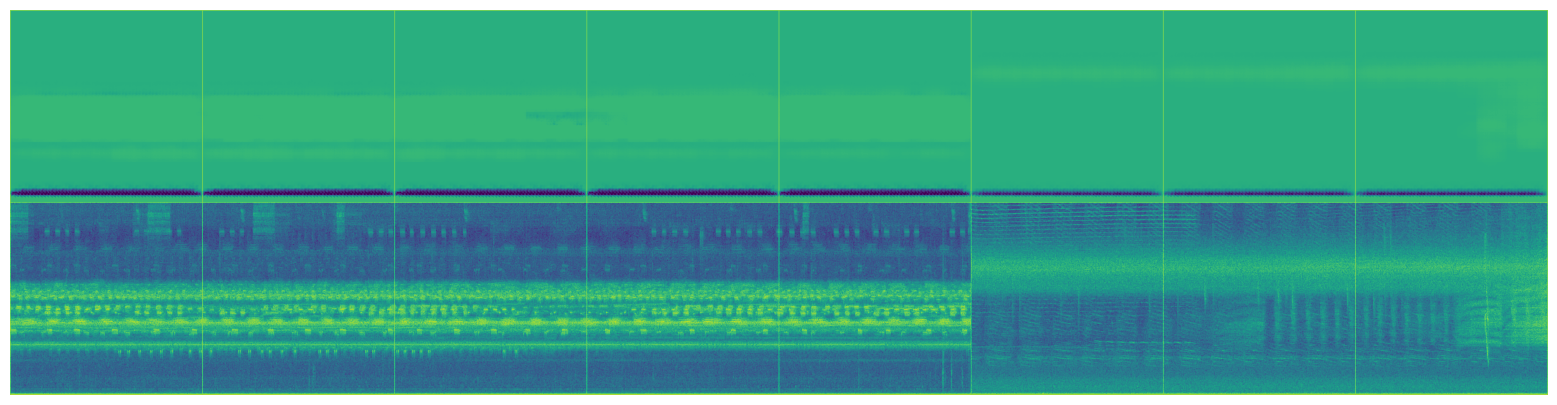

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 201 of 1188 	 loss: 356.6886
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 202 of 1188 	 loss: 235.0507
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 203 of 1188 	 loss: 537.1378
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 204 of 1188 	 loss: 4261.2725
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 205 of 1188 	 loss: 320.4314
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 206 of 1188 	 loss: 170.2324
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 207 of

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 258 of 1188 	 loss: 896.1223
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 259 of 1188 	 loss: 253.0597
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 260 of 1188 	 loss: 379.6979
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 261 of 1188 	 loss: 159.3528
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 262 of 1188 	 loss: 395.2506
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 263 of 1188 	 loss: 320.8302
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 264 of 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 315 of 1188 	 loss: 285.498
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 316 of 1188 	 loss: 4100.583
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 317 of 1188 	 loss: 316.4655
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 318 of 1188 	 loss: 1442.8171
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 319 of 1188 	 loss: 296.4934
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 320 of 1188 	 loss: 193.3112
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 321 of 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 372 of 1188 	 loss: 313.3379
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 373 of 1188 	 loss: 174.3479
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 374 of 1188 	 loss: 284.378
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 375 of 1188 	 loss: 317.0247
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 376 of 1188 	 loss: 207.1648
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 377 of 1188 	 loss: 370.6327
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 378 of 1

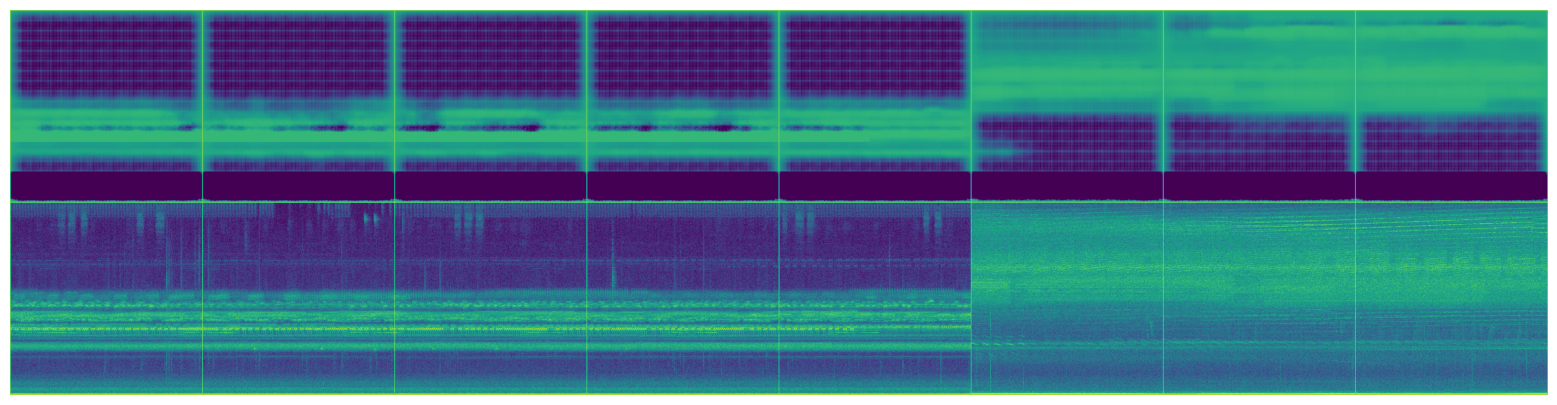

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 401 of 1188 	 loss: 290.6371
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 402 of 1188 	 loss: 368.7335
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 403 of 1188 	 loss: 783.3828
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 404 of 1188 	 loss: 234.3845
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 405 of 1188 	 loss: 302.9463
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 406 of 1188 	 loss: 272.4351
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 407 of 

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 458 of 1188 	 loss: 116.1586
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 459 of 1188 	 loss: 268.7039
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 460 of 1188 	 loss: 234.0988
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 461 of 1188 	 loss: 362.6214
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 462 of 1188 	 loss: 675.362
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 463 of 1188 	 loss: 151.7402
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 464 of 1

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 515 of 1188 	 loss: 457.5012
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 516 of 1188 	 loss: 82.6449
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 517 of 1188 	 loss: 1611.4272
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 518 of 1188 	 loss: 288.2899
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 519 of 1188 	 loss: 369.3504
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 520 of 1188 	 loss: 341.212
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 521 of 1

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 572 of 1188 	 loss: 950.3658
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 573 of 1188 	 loss: 249.7207
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 574 of 1188 	 loss: 170.8026
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 575 of 1188 	 loss: 818.8956
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 576 of 1188 	 loss: 356.6326
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 577 of 1188 	 loss: 177.5928
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 578 of 

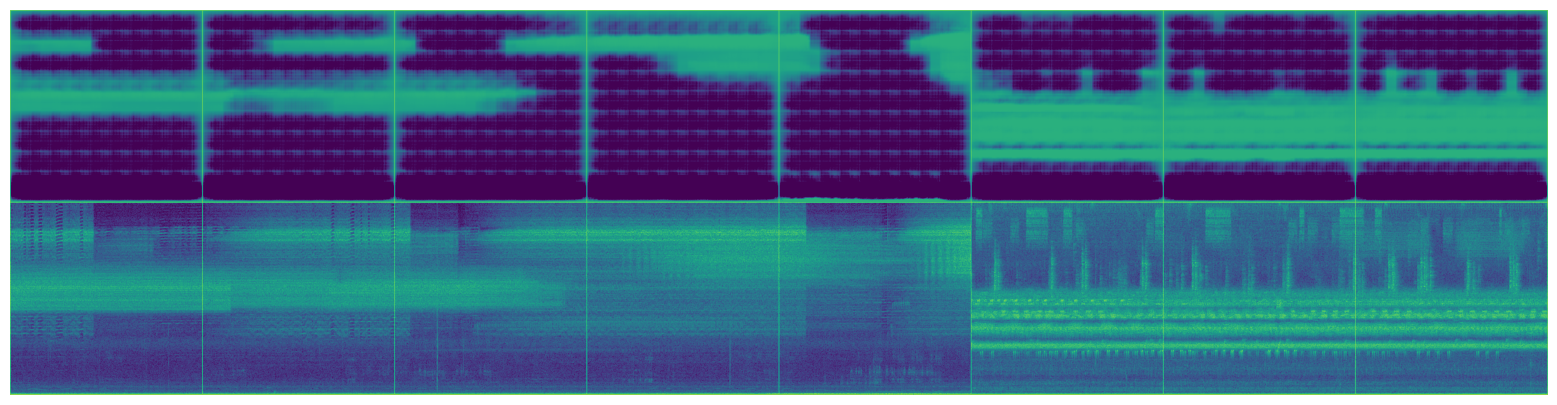

encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 601 of 1188 	 loss: 289.3444
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 602 of 1188 	 loss: 634.7294
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 603 of 1188 	 loss: 220.4633
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 604 of 1188 	 loss: 199.5379
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 605 of 1188 	 loss: 170.3137
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 606 of 1188 	 loss: 288.7596
encoder_shape:  torch.Size([70, 64, 9, 9])
decoder_shape:  torch.Size([70, 1, 515, 515])
epoch: 1 of 10 	 iteration: 607 of 

In [ ]:
Training = TrainModel(model)
model, logs, run_name = Training.fordward(training_loader, test_loader, config)
time = datetime.datetime.now()
torch.save(model.state_dict(),f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth')
torch.save(config,f'temporal/configs/config_{run_name}_day_{time.day}_hour_{time.hour}.pth')
# torch.save(dataset_test, f"temporal/datasets/dataset_test_ae_jaguas_{time.day}_70%.pth")
# torch.save(dataset_train, f"temporal/datasets/dataset_train_ae_jaguas_{time.day}_70%.pth")

In [ ]:
dataset_test = torch.load(f'temporal/dataset_test_ae_jaguas')
dataset_train = torch.load(f'temporal/dataset_train_ae_jaguas')
model.load_state_dict(torch.load(f'temporal/models/model_{run_name}_day_{time.day}_hour_{time.hour}_final.pth', map_location=torch.device('cpu')))

In [ ]:
# root_path = '/content/drive/Shareddrives/ConservacionBiologicaIA/Datos/Porce_2019'


# dataset = SoundscapeData(root_path, audio_length=12, ext="WAV", win_length=1028)
# dataset_train, dataset_test = random_split(dataset,
#                                            [round(len(dataset)*0.7), len(dataset) - round(len(dataset)*0.7)], 
#                                            generator=torch.Generator().manual_seed(1024))
# Dataset_train = DataLoader(dataset_train, batch_size=54, shuffle=True)
# Dataset = DataLoader(dataset_test, batch_size=54, shuffle=True)

training_loader = DataLoader(dataset_train, batch_size=100)
test_loader = DataLoader(dataset_test, batch_size=100)
iterator = iter(test_loader)
testing = TestModel(model, iterator, device=torch.device("cuda"))


In [ ]:
originals, reconstructions, encodings, label, loss= testing.run()

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin[0:4],2)
testing.plot_psd(wav_origin[10:14],2)
#testing.plot_psd(wav_origin[18:22],2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons[0:4],2)
testing.plot_psd(wav_recons[10:14],2)
#testing.plot_psd(wav_recons[18:22],2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)

In [ ]:
wav_origin=testing.waveform_generator(spec=originals)
print(wav_origin[0:1])
wav_origin = np.interp(wav_origin, (wav_origin.min(), wav_origin.max()), (-1, +1))
print(wav_origin[0:1])
wav_recons=testing.waveform_generator(spec=reconstructions)
wav_recons= np.interp(wav_recons, (wav_recons.min(), wav_recons.max()), (-1, +1))
testing.plot_psd(wav_origin,2)
plt.savefig("original_psd.pdf")
plt.figure()
testing.plot_psd(wav_recons,2)
plt.savefig("recon_psd.pdf")
wav_diff = wav_origin-wav_recons
plt.figure()
testing.plot_psd(wav_diff,4)


In [ ]:
plt.plot(wav_origin[12,0])
plt.plot(wav_recons[12,0], color='red', alpha = 0.4)